<a href="https://www.kaggle.com/code/taisei7/melting-point-prediction-rdkit-optuna?scriptVersionId=272606714" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

<div style="background-color: #004a99; padding: 25px; border-radius: 10px; text-align: center; margin-bottom: 25px;">
    <h1 style="color: #ffffff; margin: 0; font-size: 2.5em; font-weight: bold;">
         Melting Point Prediction 
    </h1>
    <p style="color: #e0f2f7; font-size: 1.4em; margin-top: 10px;">
        RDKit Feature Engineering & Optuna Tuning
    </p>
</div>

<table width="100%" border="2" bordercolor="#aed6f1" cellspacing="0" cellpadding="30" bgcolor="#ffffff" style="border-radius: 10px;">
<tr>
<td>

<h2 style="color: #2980b9; border-bottom: 3px solid #aed6f1; padding-bottom: 5px; font-size: 1.8em; margin-top: 0px;">
    🎯 1.1. Objective
</h2>
<p style="font-size: 1.1em; color: #34495e; line-height: 1.6;">
    The primary goal of this notebook is to build a high-performance regression model to predict the <b>Melting Point (Tm)</b> of organic compounds. We will use RKit for advanced feature engineering, Optuna for hyperparameter tuning, and an ensemble of GBDT models to achieve the best possible MAE score.
</p>

<h2 style="color: #2980b9; border-bottom: 3px solid #aed6f1; padding-bottom: 5px; font-size: 1.8em; margin-top: 25px;">
    💾 1.2. Dataset
</h2>
<p style="font-size: 1.1em; color: #34495e; line-height: 1.6;">
    The training dataset contains molecular formulas (in <b>SMILES</b> format), the target variable (<b>Tm</b>), and 400+ anonymous <b>'Group'</b> features, which represent molecular descriptors.
</p>

<h2 style="color: #2980b9; border-bottom: 3px solid #aed6f1; padding-bottom: 5px; font-size: 1.8em; margin-top: 25px;">
    🚀 1.3. Our Approach (Pipeline)
</h2>
<p style="font-size: 1.1em; color: #34495e; line-height: 1.6;">
    Our analysis follows a structured path from data to a high-score submission:
</p>
<ul style="font-size: 1.1em; color: #34495e; line-height: 1.7; margin-top: 10px;">
    <li><b>Data Cleaning:</b> Load data and drop constant (useless) features.</li>
    <li><b>Feature Engineering (RDKit):</b> Generate 200+ molecular descriptors from SMILES.</li>
    <li><b>Feature Selection:</b> Use LGBM's <code>feature_importance_</code> to select only predictive features.</li>
    <li><b>Advanced CV Modeling:</b> Build a robust <code>train_cv</code> function for LGBM, XGBoost, and CatBoost.</li>
    <li><b>Hyperparameter Tuning (Optuna):</b> Optimize all 3 models using GPU-accelerated Optuna.</li>
    <li><b>Ensembling:</b> Blend the predictions of the three tuned models (LGBM + XGB + CatBoost) to achieve the final score.</li>
</ul>

</td>
</tr>
</table>

<blockquote style="background-color: #f0f8ff; border-left: 10px solid #1a73e8; padding: 20px; margin: 10px 0;">

<h2 style="color: #1a73e8; margin-top: 0px; padding-bottom: 5px; border-bottom: 2px solid #d0e0f0;">
     Final CV Score (Ensemble): 24.87528 MAE
</h2>

<p style="font-size: 16px; color: #333;">
    This Notebook explains all steps to achieve <strong>MAE 24.87528</strong> through feature engineering with RDKit, hyperparameter tuning with Optuna, and ensemble (blending) of three models (LGBM, XGBoost, CatBoost).
</p>

<strong style="color: #1a73e8; font-size: 17px;">Pipeline Overview:</strong>
<ul style="font-size: 16px; color: #333; list-style-type: '✔️'; margin-left: 20px; padding-left: 10px;">
    <li><strong>Feature Engineering:</strong> 500+ features from RDKit Descriptors</li>
    <li><strong>Feature Selection:</strong> <code>feature_importance_ > 0</code></li>
    <li><strong>Tuning:</strong> Optuna (with GPU)</li>
    <li><strong>Modeling:</strong> <code>train_cv</code> function (LGBM, XGB, CatBoost)</li>
    <li><strong>Ensembling:</strong> Simple Blending (Average)</li>
</ul>

<hr style="border: 0; border-top: 2px solid #d0e0f0;">

<p style="text-align: center; font-size: 18px; font-weight: bold; color: #1a73e8; margin-bottom: 0px;">
    If this Notebook is helpful, please UPVOTE! 
</p>

</blockquote>

<h1 style="color: #2980b9; border-bottom: 3px solid #aed6f1; padding-bottom: 10px; font-family: Arial, sans-serif;">
    📚 1. Importing Libraries
</h1>

In [1]:
%%capture
pip install rdkit-pypi

In [2]:
%%capture
pip install xgboost catboost

In [3]:
%%capture
pip install tqdm

In [4]:
%%capture
!pip install lightgbm

In [5]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from rich.console import Console
from rich.table import Table
#Style settings for changing the appearance of graphs in Python's Matplotlib library
plt.style.use("ggplot")
sns.set(font_scale=1.1)
from rich.box import ROUNDED

from tqdm import tqdm
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error
import lightgbm as lgb
from sklearn.preprocessing import PowerTransformer
from rdkit import Chem
from rdkit.Chem import Descriptors

from sklearn.base import clone
import xgboost as xgb
import catboost as cat

from sklearn.linear_model import LinearRegression

import optuna

/kaggle/input/melting-point/sample_submission.csv
/kaggle/input/melting-point/train.csv
/kaggle/input/melting-point/test.csv


<h1 style="color: #2980b9; border-bottom: 3px solid #aed6f1; padding-bottom: 10px; font-family: Arial, sans-serif;">
     💾 2. Load Data
</h1>

In [6]:
train = pd.read_csv("/kaggle/input/melting-point/train.csv",index_col='id')
test = pd.read_csv("/kaggle/input/melting-point/test.csv",index_col='id')
sub = pd.read_csv("/kaggle/input/melting-point/sample_submission.csv")
print("--- train data ---")
display(train.head())
print("--- test data ---")
display(test.head())

--- train data ---


,SMILES,Tm,Group 1,Group 2,Group 3,Group 4,Group 5,Group 6,Group 7,Group 8,...,Group 415,Group 416,Group 417,Group 418,Group 419,Group 420,Group 421,Group 422,Group 423,Group 424
id,,,,,,,,,,,,,,,,,,,,,
2175,FC1=C(F)C(F)(F)C1(F)F,213.15,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1222,c1ccc2c(c1)ccc3Nc4ccccc4c23,407.15,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2994,CCN1C(C)=Nc2ccccc12,324.15,2,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1704,CC#CC(=O)O,351.15,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2526,CCCCC(S)C,126.15,2,3,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


--- test data ---


,SMILES,Group 1,Group 2,Group 3,Group 4,Group 5,Group 6,Group 7,Group 8,Group 9,...,Group 415,Group 416,Group 417,Group 418,Group 419,Group 420,Group 421,Group 422,Group 423,Group 424
id,,,,,,,,,,,,,,,,,,,,,
1022,CCOC(=O)c1ccc(O)cc1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1146,CCCCCCc1ccc(O)cc1O,1,4,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
79,ClCBr,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2279,C=CCCCCCCCC,1,7,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1342,Fc1ccc(cc1)C(F)(F)F,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


<h2 style="color: #006400; border-bottom: 3px solid #aed6f1; padding-bottom: 10px; font-family: Arial, sans-serif;">
    1. Output the characteristics of the dataset in tabular format
</h2>

In [7]:
def get_numeric_stats(df):
    num_df = df.select_dtypes(include=np.number)
    if num_df.empty:
        return pd.DataFrame()

    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=RuntimeWarning)
        stats = num_df.describe().T
    
    stats['missing_count'] = num_df.isnull().sum()
    stats['missing_pct'] = (stats['missing_count'] / len(num_df) * 100)
    stats['skewness'] = num_df.skew()
    stats['kurtosis'] = num_df.kurtosis() 
    
    cols_order = [
        'count', 'missing_count', 'missing_pct', 'mean', 'std', 
        'min', '25%', '50%', '75%', 'max', 'skewness', 'kurtosis'
    ]
    stats = stats[cols_order]
    
    stats['count'] = stats['count'].astype(int)
    stats['missing_count'] = stats['missing_count'].astype(int)
    
    float_cols = stats.select_dtypes(include='float').columns
    stats[float_cols] = stats[float_cols].round(2)
    
    return stats

# Categorical Features
def get_categorical_stats(df):
    cat_df = df.select_dtypes(include=['object', 'category'])
    if cat_df.empty:
        return pd.DataFrame()

    stats = cat_df.describe().T
    stats['missing_count'] = cat_df.isnull().sum()
    stats['missing_pct'] = (stats['missing_count'] / len(cat_df) * 100)
    
    stats['unique_pct'] = (stats['unique'] / stats['count'] * 100).fillna(0)
    stats['freq_pct'] = (stats['freq'] / stats['count'] * 100).fillna(0)

    cols_order = [
        'count', 'missing_count', 'missing_pct', 'unique', 'unique_pct', 
        'top', 'freq', 'freq_pct'
    ]
    for col in cols_order:
        if col not in stats.columns:
            stats[col] = np.nan
            
    stats = stats[cols_order]

    int_cols = ['count', 'unique', 'freq', 'missing_count']
    stats[int_cols] = stats[int_cols].fillna(0).astype(int)
    
    stats['top'] = stats['top'].fillna('-')
    
    float_cols = stats.select_dtypes(include='float').columns
    stats[float_cols] = stats[float_cols].round(2)
    
    return stats



def _print_stats_table(console: Console, stats_df: pd.DataFrame, title: str):
    if stats_df.empty:
        console.print(f"[bold blue]{title}:[/bold blue] (No matching column found)\n")
        return

    console.print(f"[bold blue]{title}:[/bold blue]")
    table = Table(show_header=True, header_style="bold magenta", box=ROUNDED)
    
    table.add_column("Column", style="cyan", no_wrap=True, justify="left")
    for col in stats_df.columns:
        is_numeric = pd.api.types.is_numeric_dtype(stats_df[col])
        justify = "right" if is_numeric else "left"
        table.add_column(col, justify=justify)

    for idx, row in stats_df.iterrows():
        styled_row = [str(idx)]  
        
        for col_name, val in row.items():
            s_val = str(val)
            style = ""
            
            try:
                if col_name == 'missing_pct' and val > 20:
                    style = "bold red"
                elif col_name == 'missing_pct' and val > 0:
                    style = "yellow"
                
                elif col_name == 'skewness' and abs(val) > 1.5:
                    style = "bold yellow" 
                elif col_name == 'kurtosis' and abs(val) > 3.0: 
                    style = "bold yellow" 
                    
                elif col_name == 'unique_pct' and val > 90:
                    style = "yellow" 
                elif col_name == 'unique_pct' and val < 1:
                    style = "yellow"
            except TypeError:
                pass 
            
            if style:
                styled_row.append(f"[{style}]{s_val}[/]")
            else:
                styled_row.append(s_val)
            
        table.add_row(*styled_row)
        
    console.print(table)
    console.print("\n")


def df_summary(df, label="Train"):
    console = Console()
    console.rule(f"[bold blue]{label} DataFrame Description[/bold blue]")
    console.print(f"[bold]Shape:[/bold] {df.shape}\n")

    num_stats = get_numeric_stats(df)
    _print_stats_table(console, num_stats, "Numerical Columns")

    cat_stats = get_categorical_stats(df)
    _print_stats_table(console, cat_stats, "Categorical Columns")

df_summary(train, "Train")
df_summary(test, "Test")

─────────────────────────────────────────── Train DataFrame Description ───────────────────────────────────────────

Shape: (2662, 426)

Numerical Columns:

╭───────────┬────────┬────────┬────────┬────────┬───────┬───────┬───────┬───────┬────────┬───────┬────────┬───────╮
│ Column    │  count │ missi… │ missi… │   mean │   std │   min │   25% │   50% │    75% │   max │ skewn… │ kurt… │
├───────────┼────────┼────────┼────────┼────────┼───────┼───────┼───────┼───────┼────────┼───────┼────────┼───────┤
│ Tm        │ 2662.0 │    0.0 │    0.0 │ 278.26 │ 85.12 │ 53.54 │ 217.0 │ 277.3 │ 325.15 │ 897.… │    0.9 │  2.79 │
│ Group 1   │ 2662.0 │    0.0 │    0.0 │   1.02 │  1.35 │   0.0 │   0.0 │   1.0 │    2.0 │  16.0 │    2.5 │  13.4 │
│ Group 2   │ 2662.0 │    0.0 │    0.0 │   1.58 │  3.74 │   0.0 │   0.0 │   0.0 │    1.0 │  42.0 │   4.32 │  26.6 │
│ Group 3   │ 2662.0 │    0.0 │    0.0 │   0.11 │  0.43 │   0.0 │   0.0 │   0.0 │    0.0 │   6.0 │   5.36 │ 42.68 │
│ Group 4   │ 2662.0 │    0.0 │    0.0 │   0.04 │  0.21 │   0.0 │   0.0 │   0.0 │    0.0 │   3.0 │    6.5 │ 49.67 │
│ Group 5   │ 2662.0 │    0.0 │    0.0 │   0.04 │  0.21 │   0.0 │   0.0 │   0.0 │    0.0 │   2.0 │   6.04 │ 39.76 │
│ Group 6   │ 2662.0 │    0.0 │    0.0 │   0.02 │  0.16 │   0.0 │   0.0 │   0.0 │    0.0 │   2.0 │   7.84 │ 67.92 │
│ Group 7   │ 2662.0 │    0.0 │    0.0 │   0.01 │  0.12 │   0.0 │   0.0 │   0.0 │    0.0 │   2.0 │   9.09 │ 87.53 │
│ Group 8   │ 2662.0 │    0.0 │    0.0 │   0.01 │  0.12 │   0.0 │   0.0 │   0.0 │    0.0 │   2.0 │  12.96 │ 184.… │
│ Group 9   │ 2662.0 │    0.0 │    0.0 │   0.01 │  0.09 │   0.0 │   0.0 │   0.0 │    0.0 │   2.0 │  14.41 │ 232.… │
│ Group 10  │ 2662.0 │    0.0 │    0.0 │    0.0 │  0.03 │   0.0 │   0.0 │   0.0 │    0.0 │   1.0 │  36.46 │ 1328… │
│ Group 11  │ 2662.0 │    0.0 │    0.0 │    0.0 │  0.02 │   0.0 │   0.0 │   0.0 │    0.0 │   1.0 │  51.59 │ 2662… │
│ Group 12  │ 2662.0 │    0.0 │    0.0 │    0.0 │   0.0 │   0.0 │   0.0 │   0.0 │    0.0 │   0.0 │    0.0 │   0.0 │
│ Group 13  │ 2662.0 │    0.0 │    0.0 │   0.01 │  0.12 │   0.0 │   0.0 │   0.0 │    0.0 │   2.0 │  11.11 │ 137.… │
│ Group 14  │ 2662.0 │    0.0 │    0.0 │   0.01 │  0.08 │   0.0 │   0.0 │   0.0 │    0.0 │   1.0 │   12.4 │ 151.… │
│ Group 15  │ 2662.0 │    0.0 │    0.0 │   2.33 │  3.09 │   0.0 │   0.0 │   0.0 │    4.0 │  20.0 │   1.51 │  2.81 │
│ Group 16  │ 2662.0 │    0.0 │    0.0 │   0.13 │  0.65 │   0.0 │   0.0 │   0.0 │    0.0 │  12.0 │   7.51 │ 81.72 │
│ Group 17  │ 2662.0 │    0.0 │    0.0 │   0.07 │  0.43 │   0.0 │   0.0 │   0.0 │    0.0 │   4.0 │   7.07 │  53.5 │
│ Group 18  │ 2662.0 │    0.0 │    0.0 │    0.1 │  0.43 │   0.0 │   0.0 │   0.0 │    0.0 │   6.0 │   5.26 │ 35.31 │
│ Group 19  │ 2662.0 │    0.0 │    0.0 │   0.06 │  0.29 │   0.0 │   0.0 │   0.0 │    0.0 │   3.0 │   5.65 │ 35.87 │
│ Group 20  │ 2662.0 │    0.0 │    0.0 │   0.19 │  0.58 │   0.0 │   0.0 │   0.0 │    0.0 │   6.0 │   3.94 │ 19.23 │
│ Group 21  │ 2662.0 │    0.0 │    0.0 │   0.08 │  0.32 │   0.0 │   0.0 │   0.0 │    0.0 │   6.0 │   5.68 │ 56.57 │
│ Group 22  │ 2662.0 │    0.0 │    0.0 │   0.03 │   0.2 │   0.0 │   0.0 │   0.0 │    0.0 │   4.0 │   8.77 │ 106.… │
│ Group 23  │ 2662.0 │    0.0 │    0.0 │   0.03 │  0.18 │   0.0 │   0.0 │   0.0 │    0.0 │   3.0 │   8.29 │ 81.25 │
│ Group 24  │ 2662.0 │    0.0 │    0.0 │    0.0 │  0.07 │   0.0 │   0.0 │   0.0 │    0.0 │   1.0 │  14.21 │ 200.… │
│ Group 25  │ 2662.0 │    0.0 │    0.0 │   0.01 │  0.09 │   0.0 │   0.0 │   0.0 │    0.0 │   2.0 │  13.74 │ 208.… │
│ Group 26  │ 2662.0 │    0.0 │    0.0 │    0.0 │  0.03 │   0.0 │   0.0 │   0.0 │    0.0 │   1.0 │  29.75 │ 884.0 │
│ Group 27  │ 2662.0 │    0.0 │    0.0 │    0.0 │  0.02 │   0.0 │   0.0 │   0.0 │    0.0 │   1.0 │  51.59 │ 2662… │
│ Group 28  │ 2662.0 │    0.0 │    0.0 │    0.0 │   0.0 │   0.0 │   0.0 │   0.0 │    0.0 │   0.0 │    0.0 │   0.0 │
│ Group 29  │ 2662.0 │    0.0 │    0.0 │   0.09 │  0.35 │   0.0 │   0.0 │   0.0 │    0.0 │   5.0 │   4.85 │ 33.04 │
│ Group 30  │ 2662.0 │    0.0 │    0.0 │   0.07 │  0.28 │   0.0 │   0.0 │   0.0 │    0.0 │   3.0 │   4.56 │ 24.17 │
│ Group 31  │ 2662.0 │    0.0 │    0.0 │   0.04 │   0.2 

Categorical Columns:

╭────────┬───────┬───────────────┬─────────────┬────────┬────────────┬───────────────────┬──────┬──────────╮
│ Column │ count │ missing_count │ missing_pct │ unique │ unique_pct │ top               │ freq │ freq_pct │
├────────┼───────┼───────────────┼─────────────┼────────┼────────────┼───────────────────┼──────┼──────────┤
│ SMILES │  2662 │             0 │         0.0 │   2662 │      100.0 │ Brc1ccc(cc1)N(C)C │    1 │     0.04 │
╰────────┴───────┴───────────────┴─────────────┴────────┴────────────┴───────────────────┴──────┴──────────╯

─────────────────────────────────────────── Test DataFrame Description ────────────────────────────────────────────

Shape: (666, 425)

Numerical Columns:

╭───────────┬───────┬─────────────┬────────────┬──────┬──────┬─────┬─────┬─────┬─────┬──────┬──────────┬──────────╮
│ Column    │ count │ missing_co… │ missing_p… │ mean │  std │ min │ 25% │ 50% │ 75% │  max │ skewness │ kurtosis │
├───────────┼───────┼─────────────┼────────────┼──────┼──────┼─────┼─────┼─────┼─────┼──────┼──────────┼──────────┤
│ Group 1   │ 666.0 │         0.0 │        0.0 │ 1.12 │ 1.35 │ 0.0 │ 0.0 │ 1.0 │ 2.0 │ 10.0 │     1.66 │     4.25 │
│ Group 2   │ 666.0 │         0.0 │        0.0 │ 1.47 │ 3.32 │ 0.0 │ 0.0 │ 0.0 │ 1.0 │ 27.0 │     3.62 │    15.66 │
│ Group 3   │ 666.0 │         0.0 │        0.0 │ 0.11 │ 0.38 │ 0.0 │ 0.0 │ 0.0 │ 0.0 │  3.0 │     3.91 │     17.5 │
│ Group 4   │ 666.0 │         0.0 │        0.0 │ 0.05 │ 0.25 │ 0.0 │ 0.0 │ 0.0 │ 0.0 │  2.0 │      5.3 │    30.15 │
│ Group 5   │ 666.0 │         0.0 │        0.0 │ 0.04 │ 0.25 │ 0.0 │ 0.0 │ 0.0 │ 0.0 │  3.0 │     7.02 │    57.25 │
│ Group 6   │ 666.0 │         0.0 │        0.0 │ 0.02 │ 0.12 │ 0.0 │ 0.0 │ 0.0 │ 0.0 │  1.0 │     7.99 │    62.09 │
│ Group 7   │ 666.0 │         0.0 │        0.0 │ 0.02 │ 0.17 │ 0.0 │ 0.0 │ 0.0 │ 0.0 │  2.0 │     7.91 │    69.15 │
│ Group 8   │ 666.0 │         0.0 │        0.0 │ 0.02 │ 0.15 │ 0.0 │ 0.0 │ 0.0 │ 0.0 │  2.0 │      7.9 │     68.7 │
│ Group 9   │ 666.0 │         0.0 │        0.0 │ 0.01 │ 0.08 │ 0.0 │ 0.0 │ 0.0 │ 0.0 │  1.0 │    12.82 │   162.73 │
│ Group 10  │ 666.0 │         0.0 │        0.0 │  0.0 │  0.0 │ 0.0 │ 0.0 │ 0.0 │ 0.0 │  0.0 │      0.0 │      0.0 │
│ Group 11  │ 666.0 │         0.0 │        0.0 │  0.0 │  0.0 │ 0.0 │ 0.0 │ 0.0 │ 0.0 │  0.0 │      0.0 │      0.0 │
│ Group 12  │ 666.0 │         0.0 │        0.0 │  0.0 │  0.0 │ 0.0 │ 0.0 │ 0.0 │ 0.0 │  0.0 │      0.0 │      0.0 │
│ Group 13  │ 666.0 │         0.0 │        0.0 │ 0.02 │ 0.14 │ 0.0 │ 0.0 │ 0.0 │ 0.0 │  2.0 │     9.22 │    94.58 │
│ Group 14  │ 666.0 │         0.0 │        0.0 │  0.0 │ 0.09 │ 0.0 │ 0.0 │ 0.0 │ 0.0 │  2.0 │    20.75 │    451.4 │
│ Group 15  │ 666.0 │         0.0 │        0.0 │ 2.18 │ 2.89 │ 0.0 │ 0.0 │ 0.0 │ 4.0 │ 18.0 │      1.3 │     1.58 │
│ Group 16  │ 666.0 │         0.0 │        0.0 │ 0.13 │ 0.61 │ 0.0 │ 0.0 │ 0.0 │ 0.0 │  6.0 │     5.62 │    37.79 │
│ Group 17  │ 666.0 │         0.0 │        0.0 │ 0.09 │ 0.45 │ 0.0 │ 0.0 │ 0.0 │ 0.0 │  4.0 │     5.61 │    34.25 │
│ Group 18  │ 666.0 │         0.0 │        0.0 │  0.1 │ 0.44 │ 0.0 │ 0.0 │ 0.0 │ 0.0 │  6.0 │     6.69 │    62.19 │
│ Group 19  │ 666.0 │         0.0 │        0.0 │ 0.05 │ 0.28 │ 0.0 │ 0.0 │ 0.0 │ 0.0 │  3.0 │     6.57 │    50.51 │
│ Group 20  │ 666.0 │         0.0 │        0.0 │ 0.15 │  0.5 │ 0.0 │ 0.0 │ 0.0 │ 0.0 │  4.0 │     4.13 │    19.83 │
│ Group 21  │ 666.0 │         0.0 │        0.0 │ 0.09 │ 0.29 │ 0.0 │ 0.0 │ 0.0 │ 0.0 │  2.0 │     3.29 │    10.29 │
│ Group 22  │ 666.0 │         0.0 │        0.0 │ 0.02 │ 0.15 │ 0.0 │ 0.0 │ 0.0 │ 0.0 │  2.0 │     8.28 │    75.83 │
│ Group 23  │ 666.0 │         0.0 │        0.0 │ 0.02 │ 0.15 │ 0.0 │ 0.0 │ 0.0 │ 0.0 │  2.0 │     8.28 │    75.83 │
│ Group 24  │ 666.0 │         0.0 │        0.0 │  0.0 │ 0.07 │ 0.0 │ 0.0 │ 0.0 │ 0.0 │  1.0 │    14.83 │   218.65 │
│ Group 25  │ 666.0 │         0.0 │        0.0 │  0.0 │ 0.07 │ 0.0 │ 0.0 │ 0.0 │ 0.0 │  1.0 │    14.83 │   218.65 │
│ Group 26  │ 666.0 │         0.0 │        0.0 │  0.0 │ 0.05 │ 0.0 │ 0.0 │ 0.0 │ 0.0 │  1.0 │    18.21 │   330.49 │
│ Group 27  │ 666.0 │         0.0 │        0.0 │  0.0 │  0.0 │ 0.0 │ 0.0 │ 0.0 │ 0.0 │  0.0 │      0.0 │      0.0 │
│ Group 28  │ 666.0 │         0.0 │        0.0 │  0.0 │ 0.04 │ 0.0 │ 0.0 │ 0.0 │ 0.0 │  1.0 │    25.81 │    666.0 │
│ Group 29  │ 666.0 │         0.0 │        0.0 │ 0.08 │  0.3 │ 0.0 │ 0.0 │ 0.0 │ 0.0 │  2.0 │     4.22 │    18.78 │
│ Group 30  │ 666.0 │         0.0 │        0.0 │ 0.08 │ 0.32 │ 0.0 │ 0.0 │ 0.0 │ 0.0 │  2.0 │     4.13 │    17.68 │
│ Group 31  │ 666.0 │         0.0 │        0.0 │ 0.04 │ 0.22 │ 0.0 │ 0.0 │ 0.0 │ 0.0 │  2.0 │     5.32 │    30.45 │
│ Group 32  │ 666.0 │         0.0 │        0.0 │  0.0 │ 

Categorical Columns:

╭────────┬───────┬───────────────┬─────────────┬────────┬────────────┬──────────────┬──────┬──────────╮
│ Column │ count │ missing_count │ missing_pct │ unique │ unique_pct │ top          │ freq │ freq_pct │
├────────┼───────┼───────────────┼─────────────┼────────┼────────────┼──────────────┼──────┼──────────┤
│ SMILES │   666 │             0 │         0.0 │    666 │      100.0 │ OCCCc1ccccc1 │    1 │     0.15 │
╰────────┴───────┴───────────────┴─────────────┴────────┴────────────┴──────────────┴──────┴──────────╯

In [8]:
print("--- train data info---")
display(train.info())
print("--- test data info ---")
display(test.info())

--- train data info---
<class 'pandas.core.frame.DataFrame'>
Index: 2662 entries, 2175 to 1673
Columns: 426 entries, SMILES to Group 424
dtypes: float64(1), int64(424), object(1)
memory usage: 8.7+ MB


None

--- test data info ---
<class 'pandas.core.frame.DataFrame'>
Index: 666 entries, 1022 to 1065
Columns: 425 entries, SMILES to Group 424
dtypes: int64(424), object(1)
memory usage: 2.2+ MB


None

<h2 style="color: #006400; border-bottom: 3px solid #aed6f1; padding-bottom: 10px; font-family: Arial, sans-serif;">
    2. Check for missing values, duplicating
</h2>

In [9]:
print("--- train NaN ---") 
display(train.isnull().sum())
print("--- test NaN ---")
display(test.isnull().sum())

--- train NaN ---


SMILES       0
Tm           0
Group 1      0
Group 2      0
Group 3      0
            ..
Group 420    0
Group 421    0
Group 422    0
Group 423    0
Group 424    0
Length: 426, dtype: int64

--- test NaN ---


SMILES       0
Group 1      0
Group 2      0
Group 3      0
Group 4      0
            ..
Group 420    0
Group 421    0
Group 422    0
Group 423    0
Group 424    0
Length: 425, dtype: int64

In [10]:
num_duplicates=train.duplicated().sum()
print(f"Number of duplicate rows in train: {num_duplicates}")
if num_duplicates > 0:
    train=train.drop_duplicates()

Number of duplicate rows in train: 0


<h2 style="color: #2980b9; border-bottom: 3px solid #aed6f1; padding-bottom: 10px; font-family: Arial, sans-serif;">
     EDA --- Target Analysis ---
</h2>

--- Tm descriprtion---


count    2662.000000
mean      278.263452
std        85.117914
min        53.540000
25%       217.000000
50%       277.300000
75%       325.150000
max       897.150000
Name: Tm, dtype: float64

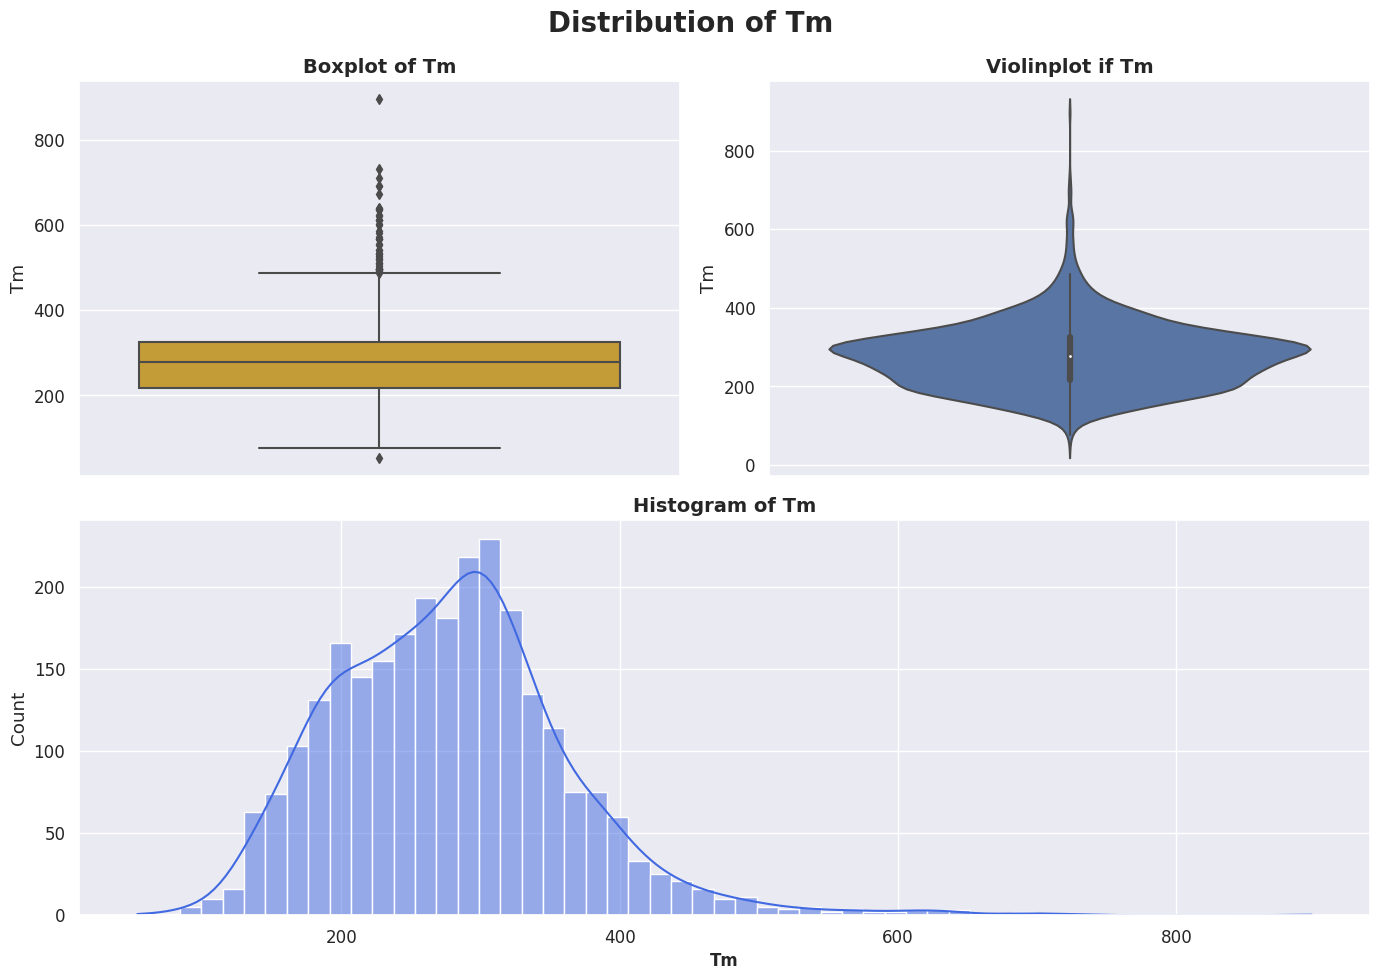

In [11]:
target="Tm"
print("--- Tm descriprtion---")
display(train[target].describe())


fig,axes=plt.subplot_mosaic([['A','B'],['C','C']],figsize=(14,10))
sns.boxplot(y=target,data=train,ax=axes['A'],color='goldenrod')
axes['A'].set_title(f"Boxplot of {target}",fontweight="bold",fontsize=14)
sns.violinplot(y=target,data=train,ax=axes['B'])
axes['B'].set_title(f"Violinplot if {target}",fontweight="bold",fontsize=14)
sns.histplot(train[target],kde=True,ax=axes['C'],color='royalblue')
axes['C'].set_title(f"Histogram of {target}",fontweight="bold",fontsize=14)
axes['C'].set_xlabel(target,fontsize=12,fontweight="bold")
plt.suptitle(f"Distribution of {target}",fontsize=20,fontweight="bold")
plt.tight_layout()
plt.show()

<h2 style="color: #2980b9; border-bottom: 3px solid #aed6f1; padding-bottom: 10px; font-family: Arial, sans-serif;">
     Drop Constant Features
</h2>

In [12]:
X=train[[col for col in train.columns if col.startswith('Group')]]
y=train[target]
X_test=test[[col for col in train.columns if col.startswith('Group')]]


constant_features = [col for col in X.columns if X[col].nunique() == 1]
print(f"Dropping {len(constant_features)} constant features")

X = X.drop(columns=constant_features)
X_test = X_test.drop(columns=constant_features)

Dropping 87 constant features


<table width="100%" border="0" cellspacing="0" cellpadding="20" style="background-color: #fdfdfd; border: 1px solid #e0e0e0; border-radius: 8px;">
    
    <tr style="background-color: #fffaf0;">
        <td style="border-bottom: 2px dashed #f0ad4e; padding-bottom: 15px;">
            <p style="font-size: 1.3em; font-weight: bold; color: #d9534f; margin: 0;">
                ❓ Q: Why is it better to drop constant_features?
            </p>
        </td>
    </tr>
    
    <tr>
        <td style="padding-top: 20px;">
            <p style="font-size: 1.3em; font-weight: bold; color: #0275d8; margin: 0 0 10px 0;">
                💡 A: There are two main reasons:
            </p>
            
            <ul style="font-size: 1.1em; color: #34495e; line-height: 1.6; margin-left: 20px; padding-left: 10px;">
                <li style="margin-bottom: 10px;">
                    <strong>Zero information content:</strong>
                    <br>
                    Constant features hold the same value across all samples. They provide no discriminatory power and contribute nothing to learning.
                </li>
                <li>
                    <strong>Compromises model accuracy and interpretability:</strong>
                    <br>
                    They may be treated as noise by the model. Meaningless features can also cause misinterpretation when analyzing feature importance.
                </li>
            </ul>
        </td>
    </tr>

</table>

<h1 style="color: #2980b9; border-bottom: 3px solid #aed6f1; padding-bottom: 10px; font-family: Arial, sans-serif;">
     3. Cross Validation
</h1>

In [13]:
def train_lgbm_cv(X, y, X_test, n_splits=5, random_state=42):    
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    
    oof_predictions = np.zeros(X.shape[0])
    test_predictions = np.zeros(X_test.shape[0])
    fold_mae_scores = []
    
    print(f"Starting training with {n_splits}-Fold CV (with Yeo-Johnson)...")
    
    for fold, (train_index, val_index) in enumerate(kf.split(X, y)):
        print(f"--- Fold {fold+1}/{n_splits} ---")
        
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]

        yeo = PowerTransformer(method='yeo-johnson')

        y_train_tf = yeo.fit_transform(y_train.values.reshape(-1, 1)).squeeze()
        y_val_tf = yeo.transform(y_val.values.reshape(-1, 1)).squeeze()
        
        lgb_params = {
            'objective': 'mae',
            'metric': 'mae',
            'verbose': -1,
            'n_jobs': -1,
            'seed': random_state + fold, 
        }
        
        model = lgb.LGBMRegressor(**lgb_params)

        model.fit(X_train, y_train_tf,  
                  eval_set=[(X_val, y_val_tf)], 
                  eval_metric='mae',
                  callbacks=[lgb.early_stopping(100, verbose=False)])

        val_preds_tf = model.predict(X_val)
        val_preds = yeo.inverse_transform(val_preds_tf.reshape(-1, 1)).squeeze()
        
        oof_predictions[val_index] = val_preds
        test_preds_tf = model.predict(X_test)
        test_preds_fold = yeo.inverse_transform(test_preds_tf.reshape(-1, 1)).squeeze()
        
        test_predictions += test_preds_fold / n_splits 
        
        mae = mean_absolute_error(y_val, val_preds)
        fold_mae_scores.append(mae)
        print(f"Fold {fold+1} MAE: {mae:.4f}")

    overall_oof_mae = mean_absolute_error(y, oof_predictions)
    print(f"\n--- Overall OOF MAE: {overall_oof_mae:.4f} ---")
    
    mean_fold_mae = np.mean(fold_mae_scores)
    std_fold_mae = np.std(fold_mae_scores)
    print(f"Mean Fold MAE: {mean_fold_mae:.4f} (+/- {std_fold_mae:.4f})")
    
    return oof_predictions, test_predictions, mean_fold_mae


oof_preds, test_preds, avg_mae = train_lgbm_cv(X, y, X_test)

Starting training with 5-Fold CV (with Yeo-Johnson)...
--- Fold 1/5 ---
Fold 1 MAE: 42.7695
--- Fold 2/5 ---
Fold 2 MAE: 38.8423
--- Fold 3/5 ---
Fold 3 MAE: 38.7630
--- Fold 4/5 ---
Fold 4 MAE: 42.0030
--- Fold 5/5 ---
Fold 5 MAE: 39.8512

--- Overall OOF MAE: 40.4461 ---
Mean Fold MAE: 40.4458 (+/- 1.6481)


<h1 style="color: #2980b9; border-bottom: 3px solid #aed6f1; padding-bottom: 10px; font-family: Arial, sans-serif;">
     4. Generate RDKit Features
</h1>

In [14]:
train = pd.read_csv("/kaggle/input/melting-point/train.csv")
test = pd.read_csv("/kaggle/input/melting-point/test.csv")

def generate_rdkit_features(smiles_string):
    mol = Chem.MolFromSmiles(smiles_string)
    if mol is None: return {desc[0]: np.nan for desc in Descriptors._descList}
    return {desc[0]: desc[1](mol) for desc in Descriptors._descList}

print("--- Generating all RDKit features (train) ---")
tqdm.pandas(desc="Train Features")
rdkit_features_train_df = pd.DataFrame(train['SMILES'].apply(generate_rdkit_features).tolist())

print("--- Generating all RDKit features (test) ---")
tqdm.pandas(desc="Test Features")
rdkit_features_test_df = pd.DataFrame(test['SMILES'].apply(generate_rdkit_features).tolist())

print("--- Group features are being prepared. ---")
features = [col for col in train.columns if col.startswith('Group')]
X_group = train[features]
X_test_group = test[features]

constant_features = [col for col in X_group.columns if X_group[col].nunique() == 1]
print(f"Dropping {len(constant_features)} constant features...")
X_group = X_group.drop(columns=constant_features)
X_test_group = X_test_group.drop(columns=constant_features)


print("--- Combining Group Features and RDKit Features ---")
X_enriched = pd.concat([X_group, rdkit_features_train_df], axis=1)
X_test_enriched = pd.concat([X_test_group, rdkit_features_test_df], axis=1)

y=train[target]

if X_enriched.isnull().sum().sum() > 0:
    print("NaN was found. Filling with the median...")
    median_values = X_enriched.median()
    X_enriched = X_enriched.fillna(median_values)
    X_test_enriched = X_test_enriched.fillna(median_values)
    
else:
    print("No NaN was found.")

print("--- Aligning columns in training/test data ---")
train_cols = set(X_enriched.columns)
test_cols = set(X_test_enriched.columns)

missing_in_test = list(train_cols - test_cols)
for col in missing_in_test:
    X_test_enriched[col] = 0 

missing_in_train = list(test_cols - train_cols)
for col in missing_in_train:
    X_enriched[col] = 0 

X_test_enriched = X_test_enriched[X_enriched.columns]

print("\n--- Feature engineering completed ---")
print(f"Final training data shape: {X_enriched.shape}")
print(f"Final test data shape: {X_test_enriched.shape}")

--- Generating all RDKit features (train) ---
--- Generating all RDKit features (test) ---
--- Group features are being prepared. ---
Dropping 87 constant features...
--- Combining Group Features and RDKit Features ---
No NaN was found.
--- Aligning columns in training/test data ---

--- Feature engineering completed ---
Final training data shape: (2662, 545)
Final test data shape: (666, 545)


In [15]:
print(f"\n--- Begin training with ENRICHED ({X_enriched.shape[1]} features) ---")

oof_preds_enriched, test_preds_enriched, avg_mae_enriched = train_lgbm_cv(X_enriched,y,X_test_enriched)

print(f"\n--- Training Complete ---")
print(f"Overall OOF MAE (Enriched): {avg_mae_enriched:.4f}")


--- Begin training with ENRICHED (545 features) ---
Starting training with 5-Fold CV (with Yeo-Johnson)...
--- Fold 1/5 ---
Fold 1 MAE: 30.5463
--- Fold 2/5 ---
Fold 2 MAE: 29.6506
--- Fold 3/5 ---
Fold 3 MAE: 28.4371
--- Fold 4/5 ---
Fold 4 MAE: 29.9007
--- Fold 5/5 ---
Fold 5 MAE: 30.2265

--- Overall OOF MAE: 29.7525 ---
Mean Fold MAE: 29.7522 (+/- 0.7235)

--- Training Complete ---
Overall OOF MAE (Enriched): 29.7522


In [16]:
sub[target]=test_preds_enriched
sub.to_csv("submission.csv",index=False)
print(sub.head())

     id          Tm
0  1022  336.274877
1  1146  340.139896
2    79  192.435050
3  2279  190.176420
4  1342  237.628323


<h1 style="color: #2980b9; border-bottom: 3px solid #aed6f1; padding-bottom: 10px; font-family: Arial, sans-serif;">
     4. Model Training
</h1>

In [17]:
from sklearn.base import clone
import xgboost as xgb
import catboost as cat
def train_cv(model_base, model_name, X, y, X_test, n_splits=5, random_state=42):
    
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    oof_predictions = np.zeros(X.shape[0])
    test_predictions = np.zeros(X_test.shape[0])
    fold_mae_scores = []
    
    print(f"--- Starting {model_name} training with {n_splits}-Fold CV ---")
    
    for fold, (train_index, val_index) in enumerate(kf.split(X, y)):
        print(f"--- Fold {fold+1}/{n_splits} ---")
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]

        model = clone(model_base) 
        
        if isinstance(model, cat.CatBoostRegressor):
            model.set_params(random_seed=random_state + fold)
        else:
            model.set_params(random_state=random_state + fold)
        
        
        if isinstance(model, lgb.LGBMRegressor):
            model.fit(X_train, y_train,
                      eval_set=[(X_val, y_val)],
                      eval_metric='mae',
                      callbacks=[lgb.early_stopping(100, verbose=False)])
            
        elif isinstance(model, xgb.XGBRegressor):
            model.fit(X_train, y_train,
                      eval_set=[(X_val, y_val)],
                      early_stopping_rounds=100,
                      verbose=False)
            
        elif isinstance(model, cat.CatBoostRegressor):
            model.fit(X_train, y_train,
                      eval_set=[(X_val, y_val)],
                      early_stopping_rounds=100,
                      verbose=0)
        else:
            model.fit(X_train, y_train)

        val_preds = model.predict(X_val)
        oof_predictions[val_index] = val_preds
        test_predictions += model.predict(X_test) / n_splits
        
        mae = mean_absolute_error(y_val, val_preds)
        fold_mae_scores.append(mae)
        print(f"Fold {fold+1} MAE: {mae:.4f}")

    overall_oof_mae = mean_absolute_error(y, oof_predictions)
    print(f"\n--- Overall {model_name} OOF MAE: {overall_oof_mae:.4f} ---")
    
    mean_fold_mae = np.mean(fold_mae_scores)
    std_fold_mae = np.std(fold_mae_scores)
    print(f"Mean Fold MAE: {mean_fold_mae:.4f} (+/- {std_fold_mae:.4f})")
    
    return oof_predictions, test_predictions, mean_fold_mae

lgbm = lgb.LGBMRegressor(
    objective='mae',
    metric='mae',
    n_estimators=2000,
    learning_rate=0.01,
    verbose=-1,
    n_jobs=-1,

)

xgbr = xgb.XGBRegressor(
    objective='reg:absoluteerror',
    eval_metric='mae',
    n_estimators=2000,
    learning_rate=0.01,
    n_jobs=-1,
    tree_method='gpu_hist',     
    predictor='gpu_predictor'   

)

catr = cat.CatBoostRegressor(
    loss_function='MAE',
    eval_metric='MAE',
    iterations=2000,
    learning_rate=0.01,
    verbose=0,
)

In [18]:
oof_lgbm, test_lgbm, mae_lgbm = train_cv(lgbm, "LGBM", X_enriched, y, X_test_enriched)
oof_xgb, test_xgb, mae_xgb = train_cv(xgbr, "XGBoost", X_enriched, y, X_test_enriched)
oof_cat, test_cat, mae_cat = train_cv(catr, "CatBoost", X_enriched, y, X_test_enriched)

--- Starting LGBM training with 5-Fold CV ---
--- Fold 1/5 ---
Fold 1 MAE: 29.6999
--- Fold 2/5 ---
Fold 2 MAE: 27.9929
--- Fold 3/5 ---
Fold 3 MAE: 27.6096
--- Fold 4/5 ---
Fold 4 MAE: 28.8420
--- Fold 5/5 ---
Fold 5 MAE: 28.9212

--- Overall LGBM OOF MAE: 28.6133 ---
Mean Fold MAE: 28.6131 (+/- 0.7376)
--- Starting XGBoost training with 5-Fold CV ---
--- Fold 1/5 ---
Fold 1 MAE: 30.5270
--- Fold 2/5 ---
Fold 2 MAE: 28.4282
--- Fold 3/5 ---
Fold 3 MAE: 28.7214
--- Fold 4/5 ---
Fold 4 MAE: 29.6611
--- Fold 5/5 ---
Fold 5 MAE: 29.1160

--- Overall XGBoost OOF MAE: 29.2909 ---
Mean Fold MAE: 29.2907 (+/- 0.7435)
--- Starting CatBoost training with 5-Fold CV ---
--- Fold 1/5 ---
Fold 1 MAE: 30.2033
--- Fold 2/5 ---
Fold 2 MAE: 28.9515
--- Fold 3/5 ---
Fold 3 MAE: 28.5704
--- Fold 4/5 ---
Fold 4 MAE: 29.0653
--- Fold 5/5 ---
Fold 5 MAE: 28.7919

--- Overall CatBoost OOF MAE: 29.1168 ---
Mean Fold MAE: 29.1165 (+/- 0.5682)


In [19]:
ensemble_preds = (test_lgbm + test_xgb + test_cat) / 3

sub[target]=ensemble_preds

sub.to_csv("submission_ensemble.csv", index=False)
print("\nEnsemble prediction ‘submission_ensemble.csv’ has been created!")
print(sub.head())


Ensemble prediction ‘submission_ensemble.csv’ has been created!
     id          Tm
0  1022  339.964647
1  1146  339.243641
2    79  190.499956
3  2279  193.893447
4  1342  238.928062


<h1 style="color: #2980b9; border-bottom: 3px solid #aed6f1; padding-bottom: 10px; font-family: Arial, sans-serif;">
     6. Importance Measurement
</h1>

<h3 style="color:red;font-weight:bold;"> Q.Why should we drop data of low importance?</h3>


<h3 style="color:blue;font-weight:bold;">
A.
    
1. reduce Overfitting
   
   - Low-importance features often add noise rather than signal.

   
   - Removing them helps the model focus on truly predictive variables, improving generalization to unseen data.

2. Improve Model Interpretability

   - Fewer features make it easier to understand and explain the model's decisions.
   
   - This is especially valuable in regulated domains like finance, law, or healthcare.
</h3>

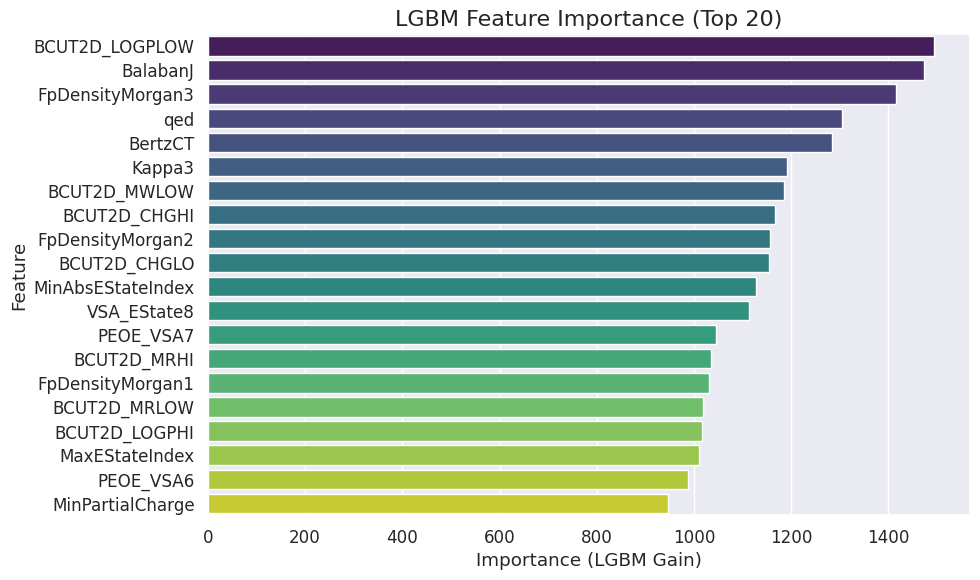


--- Select Features ---
Total number of features: 545
Number of features with importance 0: 319
Remove unnecessary features and reduce the number of features to 226.

Shape of the new training data: (2662, 226)


In [20]:
final_model_lgbm = lgbm.fit(X_enriched, y)
feature_names = X_enriched.columns
importances = final_model_lgbm.feature_importances_

importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values('importance', ascending=False) 
plt.figure(figsize=(10, 6)) 
sns.barplot(
    x='importance', 
    y='feature', 
    data=importance_df.head(20), 
    palette='viridis'
)
plt.title('LGBM Feature Importance (Top 20)', fontsize=16)
plt.xlabel('Importance (LGBM Gain)')
plt.ylabel('Feature')
plt.tight_layout() 
plt.show()

zero_importance_features = importance_df[
    importance_df['importance'] == 0
]
print(f"\n--- Select Features ---")
print(f"Total number of features: {len(importance_df)}")
print(f"Number of features with importance 0: {len(zero_importance_features)}")

selected_features = importance_df[
    importance_df['importance'] > 0
]['feature'].tolist()

print(f"Remove unnecessary features and reduce the number of features to {len(selected_features)}.")
X_enriched_selected = X_enriched[selected_features]
X_test_enriched_selected = X_test_enriched[selected_features]

print(f"\nShape of the new training data: {X_enriched_selected.shape}")

In [21]:
oof_selected_lgbm, test_selected_lgbm, mae_selected_lgbm = train_cv(lgbm, "LGBM", X_enriched_selected, y, X_test_enriched_selected)
oof_selected_xgb, test_selected_xgb, mae_selected_xgb = train_cv(xgbr, "XGBoost", X_enriched_selected, y, X_test_enriched_selected)
oof_selected_cat, test_selected_cat, mae_selected_cat = train_cv(catr, "CatBoost", X_enriched_selected, y, X_test_enriched_selected)

--- Starting LGBM training with 5-Fold CV ---
--- Fold 1/5 ---
Fold 1 MAE: 29.2891
--- Fold 2/5 ---
Fold 2 MAE: 27.9296
--- Fold 3/5 ---
Fold 3 MAE: 27.7641
--- Fold 4/5 ---
Fold 4 MAE: 29.0354
--- Fold 5/5 ---
Fold 5 MAE: 28.5957

--- Overall LGBM OOF MAE: 28.5228 ---
Mean Fold MAE: 28.5228 (+/- 0.5971)
--- Starting XGBoost training with 5-Fold CV ---
--- Fold 1/5 ---
Fold 1 MAE: 29.7855
--- Fold 2/5 ---
Fold 2 MAE: 28.8013
--- Fold 3/5 ---
Fold 3 MAE: 28.6467
--- Fold 4/5 ---
Fold 4 MAE: 29.4426
--- Fold 5/5 ---
Fold 5 MAE: 28.1894

--- Overall XGBoost OOF MAE: 28.9733 ---
Mean Fold MAE: 28.9731 (+/- 0.5711)
--- Starting CatBoost training with 5-Fold CV ---
--- Fold 1/5 ---
Fold 1 MAE: 30.1963
--- Fold 2/5 ---
Fold 2 MAE: 29.1998
--- Fold 3/5 ---
Fold 3 MAE: 28.6153
--- Fold 4/5 ---
Fold 4 MAE: 29.3571
--- Fold 5/5 ---
Fold 5 MAE: 28.5291

--- Overall CatBoost OOF MAE: 29.1799 ---
Mean Fold MAE: 29.1795 (+/- 0.6012)


<h1 style="color: #2980b9; border-bottom: 3px solid #aed6f1; padding-bottom: 10px; font-family: Arial, sans-serif;">
     7. Stacking
</h1>

In [22]:
X_level2_train = pd.DataFrame({
    'lgbm': oof_selected_lgbm,
    'xgb': oof_selected_xgb,
    'cat': oof_selected_cat
})

X_level2_test = pd.DataFrame({
    'lgbm': test_selected_lgbm,
    'xgb': test_selected_xgb,
    'cat': test_selected_cat
})


level2_model = LinearRegression()

level2_model.fit(X_level2_train, y)

stacking_preds = level2_model.predict(X_level2_test)

oof_stacking = level2_model.predict(X_level2_train)
stacking_mae = mean_absolute_error(y, oof_stacking)
print(f"--- Stacking MAE (on OOF): {stacking_mae:.4f} ---")

sub[target] = stacking_preds
sub.to_csv("submission_stacking1.csv",index=False)
print(sub.head())

--- Stacking MAE (on OOF): 28.5366 ---
     id          Tm
0  1022  346.867347
1  1146  353.002097
2    79  188.368507
3  2279  191.967815
4  1342  238.907452


<h1 style="color: #2980b9; border-bottom: 3px solid #aed6f1; padding-bottom: 10px; font-family: Arial, sans-serif;">
     8. Optuna
</h1>

<h4 style="color:orange;font-weight:bold;">To further improve the score, perform hyperparameter tuning using Optuna.</h4>

In [23]:
optuna.logging.set_verbosity(optuna.logging.WARNING)

N_SPLITS_OPTUNA = 3 
N_TRIALS = 50 

def objective_lgbm(trial):
    params = {
        'objective': 'mae', 'metric': 'mae', 'n_estimators': 2000, 
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.05),
        'num_leaves': trial.suggest_int('num_leaves', 10, 50),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0, log=True),
        'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0, log=True),
        'random_state': 42, 'n_jobs': 1, 'verbose': -1, 'device': 'gpu', 'gpu_platform_id': 0, 'gpu_device_id': 0,
    }
    kf = KFold(n_splits=N_SPLITS_OPTUNA, shuffle=True, random_state=42)
    fold_mae_scores = []
    
    for fold, (train_index, val_index) in enumerate(kf.split(X_enriched_selected, y)):
        X_train, X_val = X_enriched_selected.iloc[train_index], X_enriched_selected.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]
        
        model = lgb.LGBMRegressor(**params)
        model.fit(X_train, y_train,
                  eval_set=[(X_val, y_val)],
                  eval_metric='mae',
                  callbacks=[lgb.early_stopping(100, verbose=False)])
        
        val_preds = model.predict(X_val)
        mae = mean_absolute_error(y_val, val_preds)
        fold_mae_scores.append(mae)
    return np.mean(fold_mae_scores)

def objective_xgb(trial):
    params = {
        'objective': 'reg:absoluteerror', 'eval_metric': 'mae', 'n_estimators': 2000,
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.05),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 20),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'lambda': trial.suggest_float('lambda', 1e-8, 10.0, log=True),
        'alpha': trial.suggest_float('alpha', 1e-8, 10.0, log=True),
        'random_state': 42, 'n_jobs': 1, 'tree_method': 'gpu_hist','predictor': 'gpu_predictor',
    }

    kf = KFold(n_splits=N_SPLITS_OPTUNA, shuffle=True, random_state=42)
    fold_mae_scores = []
    
    for fold, (train_index, val_index) in enumerate(kf.split(X_enriched_selected, y)):
        X_train, X_val = X_enriched_selected.iloc[train_index], X_enriched_selected.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]
        
        model = xgb.XGBRegressor(**params)
        model.fit(X_train, y_train,
                  eval_set=[(X_val, y_val)],
                  early_stopping_rounds=100, verbose=False)
        
        val_preds = model.predict(X_val)
        mae = mean_absolute_error(y_val, val_preds)
        fold_mae_scores.append(mae)
    return np.mean(fold_mae_scores)

def objective_cat(trial):
    params = {
        'loss_function': 'MAE', 'eval_metric': 'MAE', 'iterations': 2000,
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.05),
        'depth': trial.suggest_int('depth', 3, 10),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-8, 10.0, log=True),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'bootstrap_type': 'Bernoulli',
        'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.6, 1.0),
        'random_seed': 42, 'verbose': 0,
    }
    kf = KFold(n_splits=N_SPLITS_OPTUNA, shuffle=True, random_state=42)
    fold_mae_scores = []
    
    for fold, (train_index, val_index) in enumerate(kf.split(X_enriched_selected, y)):
        X_train, X_val = X_enriched_selected.iloc[train_index], X_enriched_selected.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]
        
        model = cat.CatBoostRegressor(**params)
        model.fit(X_train, y_train,
                  eval_set=[(X_val, y_val)],
                  early_stopping_rounds=100, verbose=0)
        
        val_preds = model.predict(X_val)
        mae = mean_absolute_error(y_val, val_preds)
        fold_mae_scores.append(mae)
    return np.mean(fold_mae_scores)

all_best_params = {}
all_best_scores = {}

# --- LGBM ---
print(f"--- Optimizing LGBM (Trials: {N_TRIALS}, Folds: {N_SPLITS_OPTUNA}, Jobs: -1) ---")
with tqdm(total=N_TRIALS, desc="Optimizing LGBM") as pbar:
    study_lgbm = optuna.create_study(direction='minimize') 
    study_lgbm.optimize(
        objective_lgbm, 
        n_trials=N_TRIALS, 
        callbacks=[lambda study, trial: pbar.update(1)],
        n_jobs=1  
    )
all_best_params['LGBM'] = study_lgbm.best_params
all_best_scores['LGBM'] = study_lgbm.best_value
print(f"LGBM Best MAE: {study_lgbm.best_value:.4f}")

# --- XGBoost ---
print(f"\n--- Optimizing XGBoost (Trials: {N_TRIALS}, Folds: {N_SPLITS_OPTUNA}, Jobs: -1) ---")
with tqdm(total=N_TRIALS, desc="Optimizing XGB") as pbar:
    study_xgb = optuna.create_study(direction='minimize') 
    study_xgb.optimize(
        objective_xgb, 
        n_trials=N_TRIALS, 
        callbacks=[lambda study, trial: pbar.update(1)],
        n_jobs=1  
    )
all_best_params['XGBoost'] = study_xgb.best_params
all_best_scores['XGBoost'] = study_xgb.best_value
print(f"XGBoost Best MAE: {study_xgb.best_value:.4f}")

# --- CatBoost ---
print(f"\n--- Optimizing CatBoost (Trials: {N_TRIALS}, Folds: {N_SPLITS_OPTUNA}, Jobs: -1) ---")
with tqdm(total=N_TRIALS, desc="Optimizing CAT") as pbar:
    study_cat = optuna.create_study(direction='minimize') 
    study_cat.optimize(
        objective_cat, 
        n_trials=N_TRIALS, 
        callbacks=[lambda study, trial: pbar.update(1)],
        n_jobs=-1 
    )
all_best_params['CatBoost'] = study_cat.best_params
all_best_scores['CatBoost'] = study_cat.best_value
print(f"CatBoost Best MAE: {study_cat.best_value:.4f}")

print("\n--- Tuning completed for all models ---")
print("Best MAE (CV) Scores:")
print(all_best_scores)
print("\nBest Parameters:")
print(all_best_params)

--- Optimizing LGBM (Trials: 50, Folds: 3, Jobs: -1) ---


Optimizing LGBM:   0%|          | 0/50 [00:00<?, ?it/s]1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
Optimizing LGBM: 100%|██████████| 50/50 [26:40<00:00, 32.02s/it]


LGBM Best MAE: 28.3318

--- Optimizing XGBoost (Trials: 50, Folds: 3, Jobs: -1) ---


Optimizing XGB: 100%|██████████| 50/50 [24:11<00:00, 29.03s/it]


XGBoost Best MAE: 28.3432

--- Optimizing CatBoost (Trials: 50, Folds: 3, Jobs: -1) ---


Optimizing CAT: 100%|██████████| 50/50 [1:27:42<00:00, 105.26s/it]

CatBoost Best MAE: 28.3348

--- Tuning completed for all models ---
Best MAE (CV) Scores:
{'LGBM': 28.33175976731428, 'XGBoost': 28.343201833362627, 'CatBoost': 28.33479794582703}

Best Parameters:
{'LGBM': {'learning_rate': 0.029684980720310353, 'num_leaves': 39, 'max_depth': 10, 'min_child_samples': 11, 'subsample': 0.7828784025508684, 'colsample_bytree': 0.8102818701413933, 'lambda_l1': 6.034131278138075e-07, 'lambda_l2': 0.002159280051754032}, 'XGBoost': {'learning_rate': 0.017486881263916797, 'max_depth': 7, 'min_child_weight': 6, 'subsample': 0.6257796112217406, 'colsample_bytree': 0.742919422786776, 'lambda': 1.0655340592876242e-08, 'alpha': 7.165890100645492e-06}, 'CatBoost': {'learning_rate': 0.044058102512705526, 'depth': 6, 'l2_leaf_reg': 5.678504286430578e-06, 'subsample': 0.8631421918805166, 'colsample_bylevel': 0.9129933714804555}}


In [24]:
print("--- Parameters found in Optuna ---")
print(f"LGBM: {all_best_params['LGBM']}")
print(f"XGB : {all_best_params['XGBoost']}")
print(f"Cat : {all_best_params['CatBoost']}")
lgbm_best_params = all_best_params['LGBM'].copy()
lgbm_best_params.update({
    'objective': 'mae',
    'metric': 'mae',
    'n_estimators': 2000, 
    'verbose': -1,
    'n_jobs': -1
})
lgbm_best = lgb.LGBMRegressor(**lgbm_best_params)

xgb_best_params = all_best_params['XGBoost'].copy()
xgb_best_params.update({
    'objective': 'reg:absoluteerror',
    'eval_metric': 'mae',
    'n_estimators': 2000,
    'n_jobs': -1,
    'tree_method': 'gpu_hist','predictor': 'gpu_predictor',
})
xgbr_best = xgb.XGBRegressor(**xgb_best_params)

cat_best_params = all_best_params['CatBoost'].copy()
cat_best_params.update({
    'loss_function': 'MAE',
    'eval_metric': 'MAE',
    'iterations': 2000,
    'verbose': 0
})
catr_best = cat.CatBoostRegressor(**cat_best_params)

--- Parameters found in Optuna ---
LGBM: {'learning_rate': 0.029684980720310353, 'num_leaves': 39, 'max_depth': 10, 'min_child_samples': 11, 'subsample': 0.7828784025508684, 'colsample_bytree': 0.8102818701413933, 'lambda_l1': 6.034131278138075e-07, 'lambda_l2': 0.002159280051754032}
XGB : {'learning_rate': 0.017486881263916797, 'max_depth': 7, 'min_child_weight': 6, 'subsample': 0.6257796112217406, 'colsample_bytree': 0.742919422786776, 'lambda': 1.0655340592876242e-08, 'alpha': 7.165890100645492e-06}
Cat : {'learning_rate': 0.044058102512705526, 'depth': 6, 'l2_leaf_reg': 5.678504286430578e-06, 'subsample': 0.8631421918805166, 'colsample_bylevel': 0.9129933714804555}


In [25]:
print(f"\n--- Begin final training with this model (Features: {X_enriched_selected.shape[1]}) ---")

oof_lgbm_best, test_lgbm_best, mae_lgbm_best = train_cv(
    lgbm_best, "LGBM (Tuned)", X_enriched_selected, y, X_test_enriched_selected
)

oof_xgb_best, test_xgb_best, mae_xgb_best = train_cv(
    xgbr_best, "XGBoost (Tuned)", X_enriched_selected, y, X_test_enriched_selected
)

oof_cat_best, test_cat_best, mae_cat_best = train_cv(
    catr_best, "CatBoost (Tuned)", X_enriched_selected, y, X_test_enriched_selected
)

print("\n--- Final CV Score After Tuning ---")
print(f"LGBM (Tuned): {mae_lgbm_best:.4f} (Optuna Score: {all_best_scores['LGBM']:.4f})")
print(f"XGB  (Tuned): {mae_xgb_best:.4f} (Optuna Score: {all_best_scores['XGBoost']:.4f})")
print(f"Cat  (Tuned): {mae_cat_best:.4f} (Optuna Score: {all_best_scores['CatBoost']:.4f})")


--- Begin final training with this model (Features: 226) ---
--- Starting LGBM (Tuned) training with 5-Fold CV ---
--- Fold 1/5 ---
Fold 1 MAE: 28.9714
--- Fold 2/5 ---
Fold 2 MAE: 27.4722
--- Fold 3/5 ---
Fold 3 MAE: 27.6269
--- Fold 4/5 ---
Fold 4 MAE: 28.1792
--- Fold 5/5 ---
Fold 5 MAE: 27.4367

--- Overall LGBM (Tuned) OOF MAE: 27.9375 ---
Mean Fold MAE: 27.9373 (+/- 0.5816)
--- Starting XGBoost (Tuned) training with 5-Fold CV ---
--- Fold 1/5 ---
Fold 1 MAE: 29.2624
--- Fold 2/5 ---
Fold 2 MAE: 27.5979
--- Fold 3/5 ---
Fold 3 MAE: 27.5682
--- Fold 4/5 ---
Fold 4 MAE: 28.5217
--- Fold 5/5 ---
Fold 5 MAE: 27.3768

--- Overall XGBoost (Tuned) OOF MAE: 28.0657 ---
Mean Fold MAE: 28.0654 (+/- 0.7185)
--- Starting CatBoost (Tuned) training with 5-Fold CV ---
--- Fold 1/5 ---
Fold 1 MAE: 28.3769
--- Fold 2/5 ---
Fold 2 MAE: 27.5896
--- Fold 3/5 ---
Fold 3 MAE: 28.4792
--- Fold 4/5 ---
Fold 4 MAE: 27.6313
--- Fold 5/5 ---
Fold 5 MAE: 27.2145

--- Overall CatBoost (Tuned) OOF MAE: 27.858

In [26]:
print("\n--- Execute the ensemble ---")

oof_ensemble = (oof_lgbm_best + oof_xgb_best + oof_cat_best) / 3
ensemble_oof_mae = mean_absolute_error(y, oof_ensemble)
print(f"Final Ensemble's OOF MAE: {ensemble_oof_mae:.4f}")

ensemble_preds = (test_lgbm_best + test_xgb_best + test_cat_best) / 3

try:
    test_ids = test['id'] 
    submission_df = pd.DataFrame({
        'id': test_ids,
        'Tm': ensemble_preds
    })
    submission_df.to_csv("submission_tuned_ensemble.csv", index=False)
    print(submission_df.head())

except NameError:
    print("An error has occurred.")


--- Execute the ensemble ---
Final Ensemble's OOF MAE: 27.6072
     id          Tm
0  1022  348.298801
1  1146  340.816146
2    79  192.475917
3  2279  198.446638
4  1342  236.349725
